## General Notes
Author: <b>Jordan Eisinger, Jr. Data Scientist </b> \
Created On: <b> 10/18/2021 </b> \
Last Updated On: <b> 11/09/2021 </b>

### Import Libraries

In [2]:
# Use 'requirements.txt' file to install necessary packages for this notebook
# Use this cell for any other installs

In [2]:
# libary imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# URL Links
from IPython.display import display, Markdown

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

### SQL Queries for Data - Daily

In [3]:
# All U2P daily net revenue (USD) for SA and WYP
query_1 = '''
SELECT
  DATE_TRUNC('day', pl.created_at AT TIME ZONE 'America/Los_Angeles') AS day,
  SUM(pl.amount_usd) AS revenue
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
WHERE 1=1
  AND pl.created_at < DATE(GETDATE() AT TIME ZONE 'UTC' AT TIME ZONE 'America/Los_Angeles') AT TIME ZONE 'America/Los_Angeles' AT TIME ZONE 'UTC' 
  AND p.site_id IN (1,12) -- SA and WYP
GROUP BY 1
ORDER BY 1
        '''

# Looker equivalent visualization
display(Markdown("[Looker Equivalent: U2P Daily Net Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=DWlJw8OqNzrqHuR8IsL4n0&toggle=dat,vis)"))


# Non-SEM (Organic) Join Revenue (USD) for SA and WYP
query_2 = '''
SELECT
  DATE_TRUNC('day', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS day,
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS revenue
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
INNER JOIN u2p_sites.customers AS c ON c.id = p.customer_id
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.user_id = c.account_id AND p.site_id = 1 AND NOT (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id AND p.site_id = 12 AND NOT (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
WHERE 1=1
  AND p.site_id = 1
  AND pl.created_at > '2016-12-31 08:00:00' 
  AND pl.created_at < DATE(GETDATE() AT TIME ZONE 'UTC' AT TIME ZONE 'America/Los_Angeles') AT TIME ZONE 'America/Los_Angeles' AT TIME ZONE 'UTC' 
GROUP BY 1 
ORDER BY 1
'''

# Looker equivalent visualizaiton (not 1-to-1, but very close)
display(Markdown("[Looker Equivalent: Non-SEM (Organic) Daily Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=GnV19ATpDTHWYstB7Lj0JU&toggle=dat,fil,vis)"))


# SEM Join Revenue (USD) for SA and WYP
query_3 = '''
SELECT
  DATE_TRUNC('day', CONVERT_TIMEZONE('utc', 'america/los_angeles', pl.created_at::timestamp)) AS day,
  SUM(CASE WHEN COALESCE(sap.id, wypa.id) IS NOT NULL THEN pl.amount_usd ELSE 0 END) AS revenue
FROM u2p_sites.paymentlogs AS pl
INNER JOIN u2p_sites.payments AS p ON p.id = pl.payment_id
INNER JOIN u2p_sites.customers AS c ON c.id = p.customer_id
LEFT OUTER JOIN seeking_arrange.profiles AS sap ON sap.id = c.account_id AND p.site_id = 1 AND (sap.referral LIKE '%bing%' OR sap.referral LIKE '%goo%')
LEFT OUTER JOIN wyp.accounts AS wypa ON wypa.id = c.account_id AND p.site_id = 12 AND (wypa.referral LIKE '%bing%' OR wypa.referral LIKE '%goo%')
WHERE 1=1
  AND pl.created_at > '2016-12-31 08:00:00' 
  AND pl.created_at < DATE(GETDATE() AT TIME ZONE 'UTC' AT TIME ZONE 'America/Los_Angeles') AT TIME ZONE 'America/Los_Angeles' AT TIME ZONE 'UTC'
GROUP BY 1 
ORDER BY 1
'''

# Looker equivalent visualizaiton (not 1-to-1, but very close)
display(Markdown("[Looker Equivalent: SEM Daily Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=0CBkZkIzGnwKl3NLE7APPy&toggle=vis)"))

[Looker Equivalent: U2P Daily Net Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=DWlJw8OqNzrqHuR8IsL4n0&toggle=dat,vis)

[Looker Equivalent: Non-SEM (Organic) Daily Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=GnV19ATpDTHWYstB7Lj0JU&toggle=dat,fil,vis)

[Looker Equivalent: SEM Daily Revenue](https://reflexmedia.looker.com/explore/use2pay_model_rs/u2p_payments_rs?qid=0CBkZkIzGnwKl3NLE7APPy&toggle=vis)

### Load & Clean Data

In [9]:
# Load existing CSV data into pandas dataframes

# 3 data sets
df_total = pd.read_csv('data/daily_revenue_total.csv')
df_non_sem = pd.read_csv('data/daily_revenue_non_sem_2017_to_2021-10-20.csv')
df_sem = pd.read_csv('data/daily_revenue_sem_2017_to_2021-10-20.csv')

# Sort values 
df_total.sort_values('day', inplace=True)
df_non_sem.sort_values('day', inplace=True)
df_sem.sort_values('day', inplace=True)

# Drop first entry (incomplete)
df_total = df_total.reset_index(drop=True)
df_total = df_total.drop(0)

df_non_sem = df_non_sem.reset_index(drop=True)
df_non_sem = df_non_sem.drop(0)

df_sem = df_sem.reset_index(drop=True)
df_sem = df_sem.drop(0)

### EDA - Plot Data

In [10]:
# Set plot size for figures
mpl.rcParams["figure.figsize"] = (15, 5)

<AxesSubplot:title={'center':'SEM Daily Revenue'}, xlabel='day'>

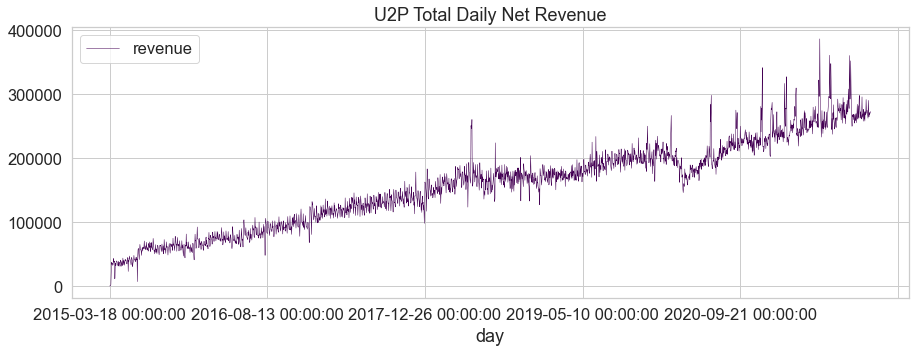

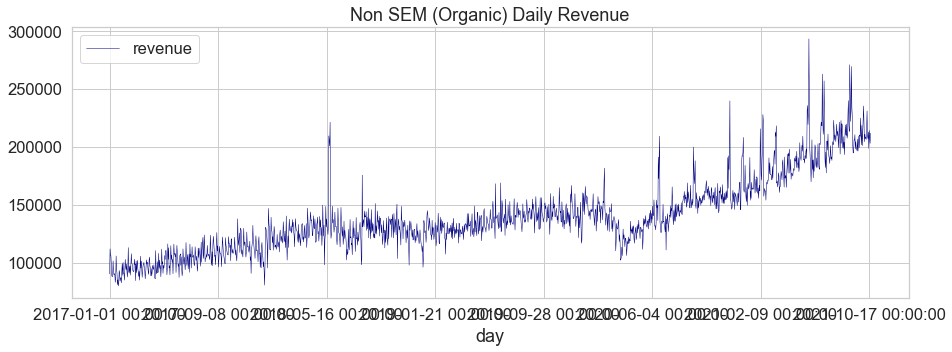

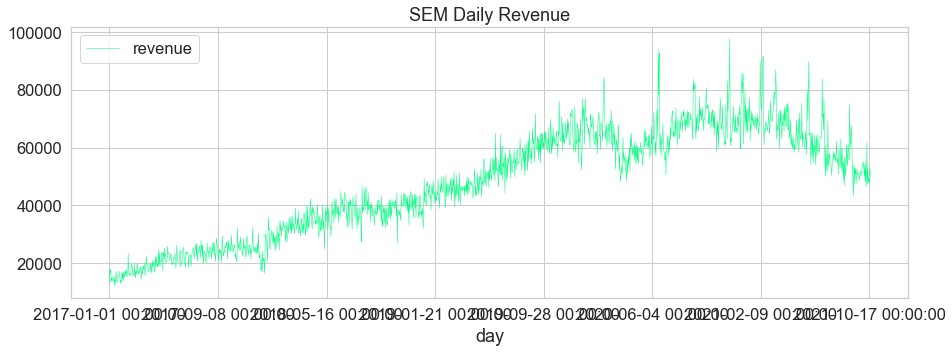

In [11]:
# Plot data
df_total.plot(x='day', y='revenue', lw=0.5, colormap='viridis', title='U2P Total Daily Net Revenue')
df_non_sem.plot(x='day', y='revenue', lw=0.5, colormap='jet', title='Non SEM (Organic) Daily Revenue')
df_sem.plot(x='day', y='revenue', lw=0.5, colormap='winter_r', title='SEM Daily Revenue')

### Reformat  & Resample Data

In [ ]:
# Reformat date field
df_total = pd.read_csv('data/daily_revenue_total.csv',
                                      parse_dates=['day'],
                                      index_col=['day'],
                                      na_values=['999.99'])

# Drop first entry (incomplete)
df_total = df_total.drop('2016-12-31')

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 5))

# Add x-axis and y-axis
ax.scatter(df_total.index.values,
          df_total['revenue'],
          color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Revenue (USD)",
       title="U2P Total Daily Revenue\n 2017-2021")

plt.show()

In [ ]:
# Resample to monthly revenue sum and save as new dataframe
df_total_monthly = df_total.resample('M').sum()

# Drop most recent month as data is incomplete
df_total_monthly = df_total_monthly.drop('2021-10-31')
df_total_monthly.tail()

In [ ]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 5))

# Add x-axis and y-axis
ax.scatter(df_total_monthly.index.values,
          df_total_monthly['revenue'],
          color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Revenue (USD)",
       title="U2P Total Monthly Revenue\n 2017-2021")

plt.show()

### AR, MA, & ARIMA Models

In [ ]:
# !pip install statsmodels
# !pip install sklearn

In [ ]:
# Import statsmodels modules
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import time series modeuls from other libraries
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import log

In [ ]:
# Define new time series variable for simplicity
ts = df_total_monthly

# Plot autocorrelation plot
autocorrelation_plot(ts)
plt.show()

In [ ]:
# Augmented Dicky-Fuller test for stationarity
test_result = adfuller(ts.dropna(),regression = 'c')
print('\nConstant:')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

test_result = adfuller(ts.revenue.dropna(),regression = 'ct')
print('\nConstant, Linear:')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

test_result = adfuller(ts.revenue.dropna(),regression = 'ctt')
print('\nConstant, Linear & Quadratic Trends:')
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

In [ ]:
# Plot original series, 1st and 2nd difference along with ACF and PACF

# Set figure size
plt.rcParams.update({'figure.figsize':(30,20)})

# Set number of subplots
fig, axes = plt.subplots(3, 3, sharex='col')

# Plot Original Series
axes[0, 0].plot(ts.revenue); axes[0, 0].set_title('Original Series')
plot_acf(ts.revenue.dropna(), ax=axes[0, 1]); axes[0, 1].set_title('Autocorrelation - Original Series')
plot_pacf(ts.revenue.dropna(), ax=axes[0,2], method='ywm'); axes[0, 2].set_title('Partical Autocorrelation - Original Series')

# Plot 1st Difference
axes[1, 0].plot(ts.revenue.diff()); axes[1, 0].set_title('1st Order Difference')
plot_acf(ts.revenue.diff().dropna(), ax=axes[1, 1]); axes[1, 1].set_title('Autocorrelation - 1st Order Diff.')
plot_pacf(ts.revenue.diff().dropna(), ax=axes[1,2], method='ywm'); axes[1,2].set_title('Partial Autocorrelation - 1st Order Diff')

# Plot 2nd Difference
axes[2, 0].plot(ts.revenue.diff().diff()); axes[2, 0].set_title('2nd Order Difference')
plot_acf(ts.revenue.diff().diff().dropna(), ax=axes[2, 1]); axes[2, 1].set_title('Autocorrelation - 2nd Order Diff.')
plot_pacf(ts.revenue.diff().diff().dropna(), ax=axes[2,2], method='ywm'); axes[2,2].set_title('Partial Autocorrelation - 2nd Order Diff')

plt.show()

## AR Model

In [ ]:
# Define series to be used in AR model development
ar_series = df_total_monthly

In [ ]:
# AR(p) model
lags = ar_select_order(ar_series, 17, trend='ct', old_names=False)
lags.ar_lags
model = lags.model.fit()

print(model.summary())

# Plot predicted values
fig = model.plot_predict('2017', '2022')
fig = model.plot_predict(50, 70)

# fig = plt.figure(figsize=(16, 9))
# fig = res.plot_diagnostics(fig=fig, lags=30)

## MA Model

## ARIMA Model

In [ ]:
import statsmodels.api as sm

# ARIMA(p,d,q) model
# model = sm.tsa.ARIMA(ts.revenue, order=(10,1,1))
# model_fit = model.fit()
# print(model_fit.summary())
# fig = model_fit.plot_predict('2017','2022')

model = ARIMA(ts.revenue, order=(10,1,1)).fit()
fig, ax = plt.subplots()
# ax = dta.loc['1950':].plot(ax=ax)
fig = model.plot_predict('2017', '2022', dynamic=True, ax=ax, plot_insample=False)
plt.show()

# # AR(p) model
# lags = ar_select_order(ar_series, 17, trend='ct', old_names=False)
# lags.ar_lags
# model = lags.model.fit()

# print(model.summary())

#
# fig = model.predict('2017', '2024')

# >>> dta.index = pd.DatetimeIndex(start='1700', end='2009', freq='A')


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
# fig, ax = plt.subplots(figsize=(10, 5))
# fig = plot_predict(model_fit, ax=ax)
fig_2 = model_fit.plot_predict('2017', '2024')
# legend = ax.legend(loc="upper left")

# Set title and labels for axes
# ax.set(xlabel="Date",
#        ylabel="Revenue (USD)",
#        title="U2P Total Monthly Revenue Forecast\n 2017-2021")

In [ ]:
# split into train and test sets
X = series_1.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(test, color='blue')
pyplot.plot(predictions, color='red')
pyplot.show()